In [4]:
setwd('data')
list.files()

[1] "prosperLoanData.csv"

In [2]:
#read data
datadf <- read.csv('prosperLoanData.csv')

In [3]:
library(plyr)
library(ggplot2)
library(dplyr)
library(stringr)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [4]:
dim(datadf)
str(datadf)

[1] 113937     81

'data.frame':	113937 obs. of  81 variables:
 $ ListingKey                         : Factor w/ 113066 levels "00003546482094282EF90E5",..: 7180 7193 6647 6669 6686 6689 6699 6706 6687 6687 ...
 $ ListingNumber                      : int  193129 1209647 81716 658116 909464 1074836 750899 768193 1023355 1023355 ...
 $ ListingCreationDate                : Factor w/ 113064 levels "2005-11-09 20:44:28.847000000",..: 14184 111894 6429 64760 85967 100310 72556 74019 97834 97834 ...
 $ CreditGrade                        : Factor w/ 9 levels "","A","AA","B",..: 5 1 8 1 1 1 1 1 1 1 ...
 $ Term                               : int  36 36 36 36 36 60 36 36 36 36 ...
 $ LoanStatus                         : Factor w/ 12 levels "Cancelled","Chargedoff",..: 3 4 3 4 4 4 4 4 4 4 ...
 $ ClosedDate                         : Factor w/ 2803 levels "","2005-11-25 00:00:00",..: 1138 1 1263 1 1 1 1 1 1 1 ...
 $ BorrowerAPR                        : num  0.165 0.12 0.283 0.125 0.246 ...
 $ BorrowerRate            

In [7]:
summary(datadf)

                   ListingKey     ListingNumber    
 17A93590655669644DB4C06:     6   Min.   :      4  
 349D3587495831350F0F648:     4   1st Qu.: 400919  
 47C1359638497431975670B:     4   Median : 600554  
 8474358854651984137201C:     4   Mean   : 627886  
 DE8535960513435199406CE:     4   3rd Qu.: 892634  
 04C13599434217079754AEE:     3   Max.   :1255725  
 (Other)                :113912                    
                    ListingCreationDate  CreditGrade         Term      
 2013-10-02 17:20:16.550000000:     6          :84984   Min.   :12.00  
 2013-08-28 20:31:41.107000000:     4   C      : 5649   1st Qu.:36.00  
 2013-09-08 09:27:44.853000000:     4   D      : 5153   Median :36.00  
 2013-12-06 05:43:13.830000000:     4   B      : 4389   Mean   :40.83  
 2013-12-06 11:44:58.283000000:     4   AA     : 3509   3rd Qu.:36.00  
 2013-08-21 07:25:22.360000000:     3   HR     : 3508   Max.   :60.00  
 (Other)                      :113912   (Other): 6745                  
        

All sorts of information there at a glance. Get to see ranges, maximums and counts. But it is a lot to take in at once, so let's dive into the individual variables that interst me.

In [10]:
names(datadf)

[1] "ListingKey"                          "ListingNumber"                      
 [3] "ListingCreationDate"                 "CreditGrade"                        
 [5] "Term"                                "LoanStatus"                         
 [7] "ClosedDate"                          "BorrowerAPR"                        
 [9] "BorrowerRate"                        "LenderYield"                        
[11] "EstimatedEffectiveYield"             "EstimatedLoss"                      
[13] "EstimatedReturn"                     "ProsperRating..numeric."            
[15] "ProsperRating..Alpha."               "ProsperScore"                       
[17] "ListingCategory..numeric."           "BorrowerState"                      
[19] "Occupation"                          "EmploymentStatus"                   
[21] "EmploymentStatusDuration"            "IsBorrowerHomeowner"                
[23] "CurrentlyInGroup"                    "GroupKey"                           
[25] "DateCreditPulled"                    "CreditScoreRangeLower"              
[27] "CreditScoreRangeUpper"               "FirstRecordedCreditLine"            
[29] "CurrentCreditLines"                  "OpenCreditLines"                    
[31] "TotalCreditLinespast7years"          "OpenRevolvingAccounts"              
[33] "OpenRevolvingMonthlyPayment"         "InquiriesLast6Months"               
[35] "TotalInquiries"                      "CurrentDelinquencies"               
[37] "AmountDelinquent"                    "DelinquenciesLast7Years"            
[39] "PublicRecordsLast10Years"            "PublicRecordsLast12Months"          
[41] "RevolvingCreditBalance"              "BankcardUtilization"                
[43] "AvailableBankcardCredit"             "TotalTrades"                        
[45] "TradesNeverDelinquent..percentage."  "TradesOpenedLast6Months"            
[47] "DebtToIncomeRatio"                   "IncomeRange"                        
[49] "IncomeVerifiable"                    "StatedMonthlyIncome"                
[51] "LoanKey"                             "TotalProsperLoans"                  
[53] "TotalProsperPaymentsBilled"          "OnTimeProsperPayments"              
[55] "ProsperPaymentsLessThanOneMonthLate" "ProsperPaymentsOneMonthPlusLate"    
[57] "ProsperPrincipalBorrowed"            "ProsperPrincipalOutstanding"        
[59] "ScorexChangeAtTimeOfListing"         "LoanCurrentDaysDelinquent"          
[61] "LoanFirstDefaultedCycleNumber"       "LoanMonthsSinceOrigination"         
[63] "LoanNumber"                          "LoanOriginalAmount"                 
[65] "LoanOriginationDate"                 "LoanOriginationQuarter"             
[67] "MemberKey"                           "MonthlyLoanPayment"                 
[69] "LP_CustomerPayments"                 "LP_CustomerPrincipalPayments"       
[71] "LP_InterestandFees"                  "LP_ServiceFees"                     
[73] "LP_CollectionFees"                   "LP_GrossPrincipalLoss"              
[75] "LP_NetPrincipalLoss"                 "LP_NonPrincipalRecoverypayments"    
[77] "PercentFunded"                       "Recommendations"                    
[79] "InvestmentFromFriendsCount"          "InvestmentFromFriendsAmount"        
[81] "Investors"

In [11]:
head(datadf$Term)

[1] 36 36 36 36 36 60

In [12]:
summary(datadf$Term)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.00   36.00   36.00   40.83   36.00   60.00 

Seems like the minimum loan term is a year, but the arithmetic mean is 40.83, a little over 3 years.

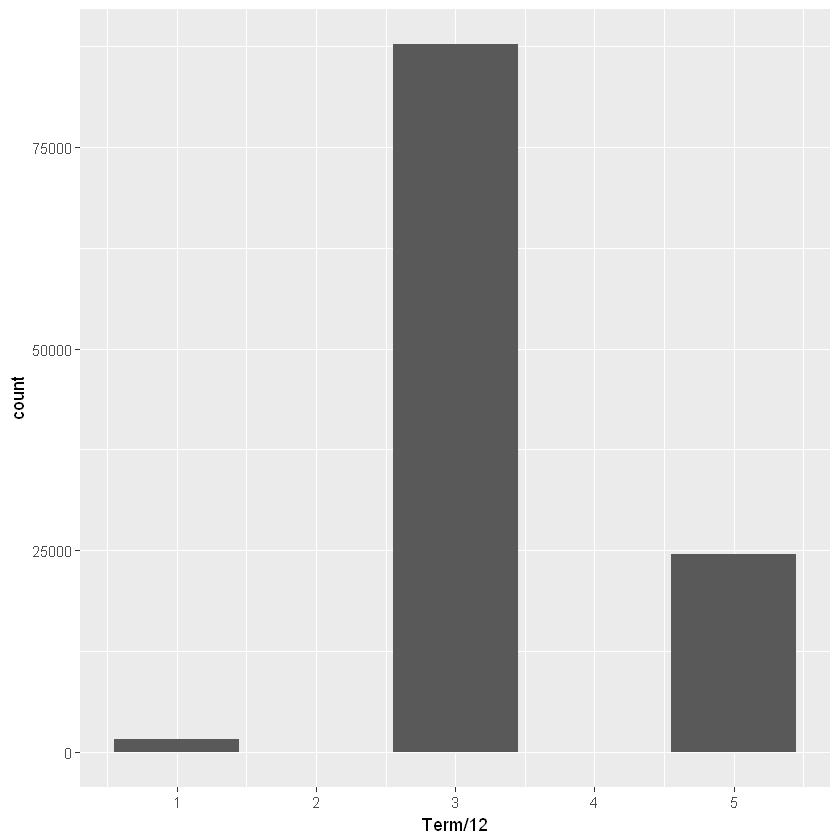

In [226]:
ggplot(datadf, aes(Term/12)) + geom_bar()
#plotting in years

Here we can see that term is discrete, and that 3 year loans far outpace 5 year loans, with 1 year loans coming in a distant third.
Later on I will explore if term influences chargeoff. If someone has a long loan term, it seems there would be more of a chance for something to go wrong in their life, but perhaps the lower monthly payments offset that danger.

In [7]:
datadf %>%
    group_by(Term) %>%
    summarise(number_per_term = n()) %>%
    mutate(percentage = number_per_term / sum(number_per_term) * 100)

Term,number_per_term,percentage
12,1614,1.416572
36,87778,77.040821
60,24545,21.542607


In [25]:
summary(datadf$LoanStatus)

[1] Completed Current   Completed Current   Current   Current  
12 Levels: Cancelled Chargedoff Completed Current ... Past Due (91-120 days)

Cancelled             Chargedoff              Completed 
                     5                  11992                  38074 
               Current              Defaulted FinalPaymentInProgress 
                 56576                   5018                    205 
  Past Due (>120 days)   Past Due (1-15 days)  Past Due (16-30 days) 
                    16                    806                    265 
 Past Due (31-60 days)  Past Due (61-90 days) Past Due (91-120 days) 
                   363                    313                    304

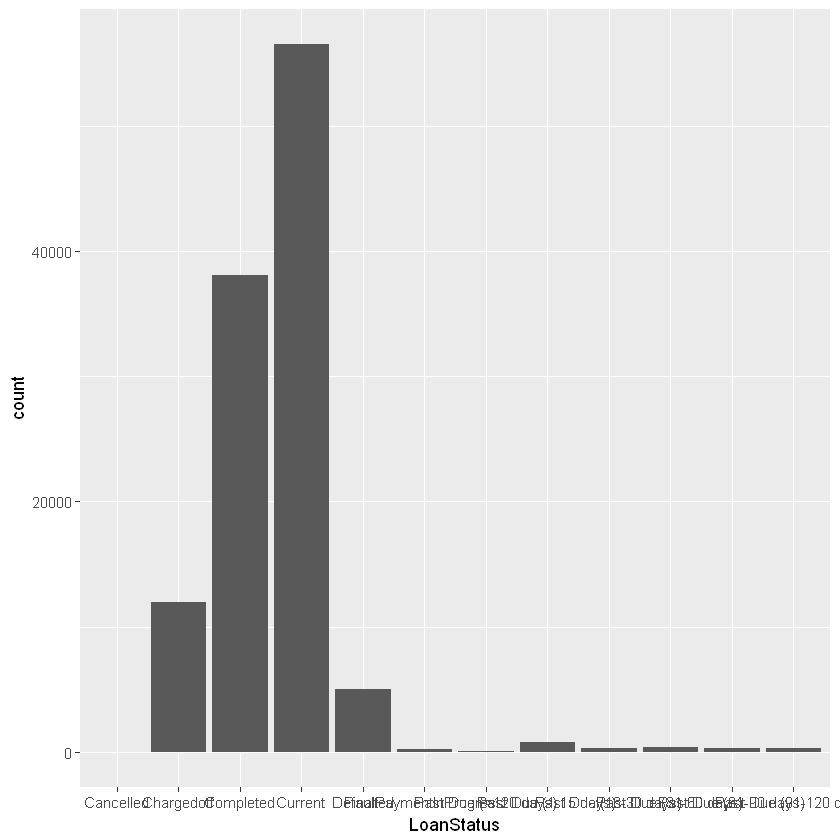

In [33]:
ggplot(datadf, aes(LoanStatus)) + geom_bar()

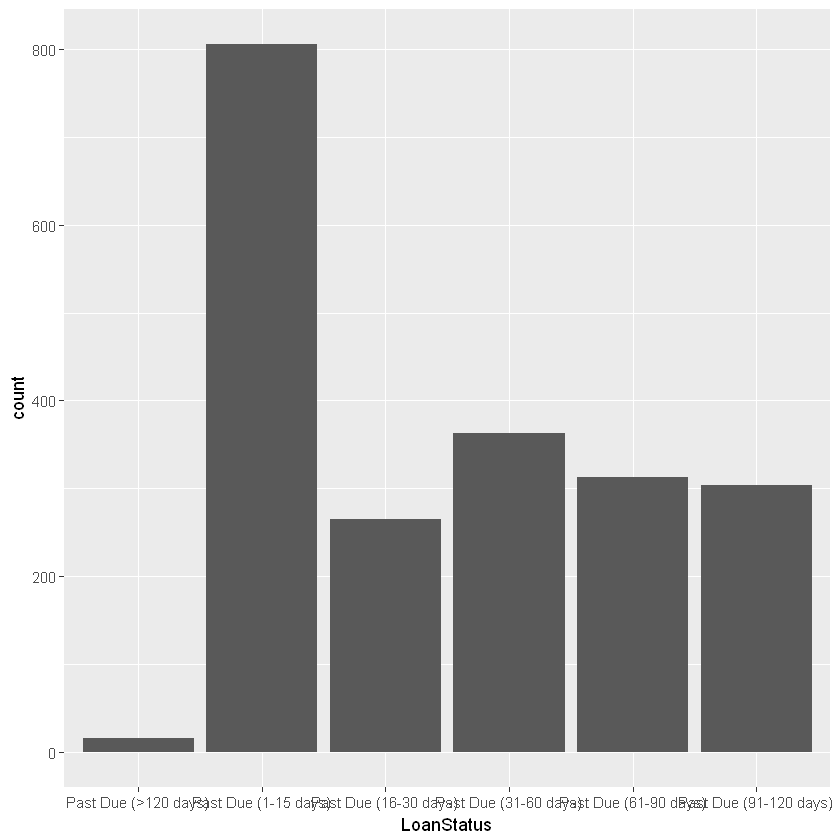

In [265]:
#plot the distribution of Past Due Loans
on_time_loans <- c('Cancelled', 'Completed', 'Chargedoff', 'Current','Defaulted','FinalPaymentInProgress')

past_due_loans <- datadf %>%
filter(!LoanStatus %in% on_time_loans)
ggplot(past_due_loans, aes(LoanStatus)) + geom_bar()

#how do you access 'the first 5 nominal vars'
#also plot the amounts late

It seems that most loans that are past due are only 1-15 days past Due. This suggests that either these loans are recoverable, or that they will quickly default. I'm not sure if loans default or need to go through the whole 120 days. Also worth noting that some of the bins here are larger than others. 

In [ ]:
#set levels to fix. possible could want to do that earlier
#levels(theTable$position) <- c(...) 
#What percentage of loans that are not Cancelled, Chargedoff or Defaulted 

In [14]:
datadf %>%
select(LoanStatus) %>%
group_by(LoanStatus) %>%
summarise(count = n()) %>%
filter(LoanStatus != 'Cancelled') %>%
rbind(c('PastDue', 1000))

Warning message in `[<-.factor`(`*tmp*`, ri, value = "PastDue"):
"invalid factor level, NA generated"

LoanStatus,count
Chargedoff,11992
Completed,38074
Current,56576
Defaulted,5018
FinalPaymentInProgress,205
Past Due (>120 days),16
Past Due (1-15 days),806
Past Due (16-30 days),265
Past Due (31-60 days),363
Past Due (61-90 days),313


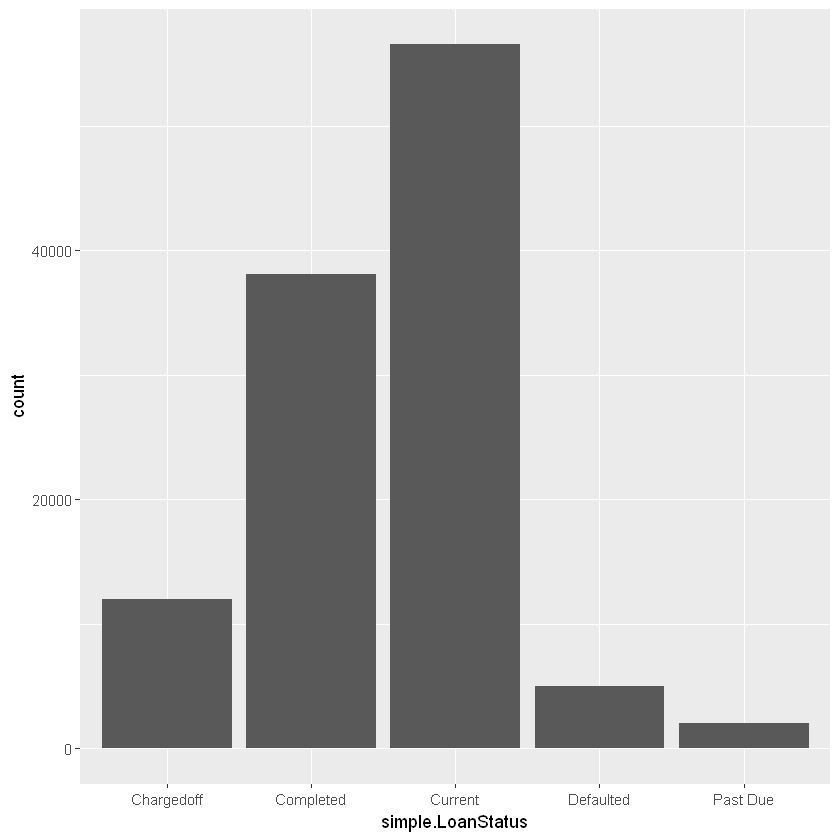

In [17]:
######Add a new, simplified LoanStatus column called simple.LoanStatus
datadf %>%
mutate(simple.LoanStatus = ifelse(str_detect(LoanStatus, "Past"), 'Past Due', as.character(LoanStatus)))%>%
filter(!str_detect(simple.LoanStatus, "Final")) %>%
filter(simple.LoanStatus != "Cancelled") %>%
ggplot(aes(simple.LoanStatus)) + geom_bar()

These LoanStatus' are intersting, but a lot depends on the data. Is this a snapshot of a month, a year? If this was for all time Completed and Defaulted will eventually become a huge part of the mix as the amount of loan history outpaces loans being originated.

In [35]:
summary(datadf$BorrowerAPR)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00653 0.15630 0.20980 0.21880 0.28380 0.51230      25 

The Borrower APR is interesting to me in several ways. First off, there are people with incredible deals and terrible deals. Our minimum is .6% - that's bascically free money. I don't know anyone getting that rate outside off the Fed. On the other end there is someone paying 51% APR. Why even bother borrowing the money? In some ways that probably means that's where the line is for risk. Prosper, or their lending partners thinks there is a positive return on someone so risky you need to charge them half their money. 

Warning message:
"Removed 25 rows containing non-finite values (stat_bin)."

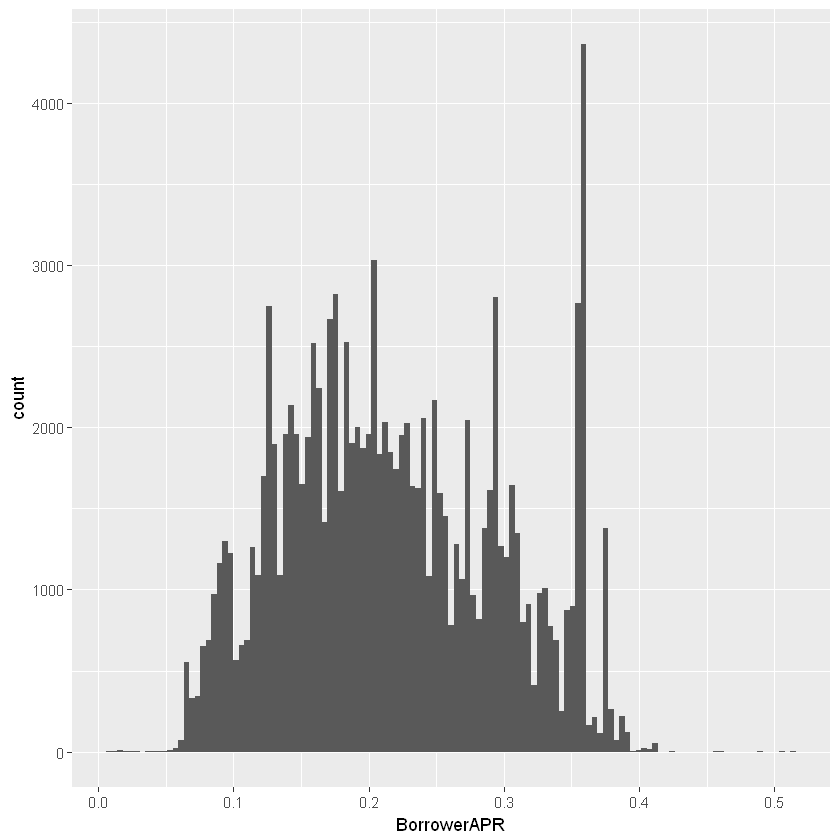

In [183]:
ggplot(datadf, aes(BorrowerAPR)) + geom_histogram(bins=125)

Several intersting things there. Spikes near round APR's. And a little but under .3. This histogram is a little noisy, so let's look at a density plot.

Warning message:
"Removed 25 rows containing non-finite values (stat_density)."

ERROR: Error in +geom_segment(x = 0.2): invalid argument to unary operator


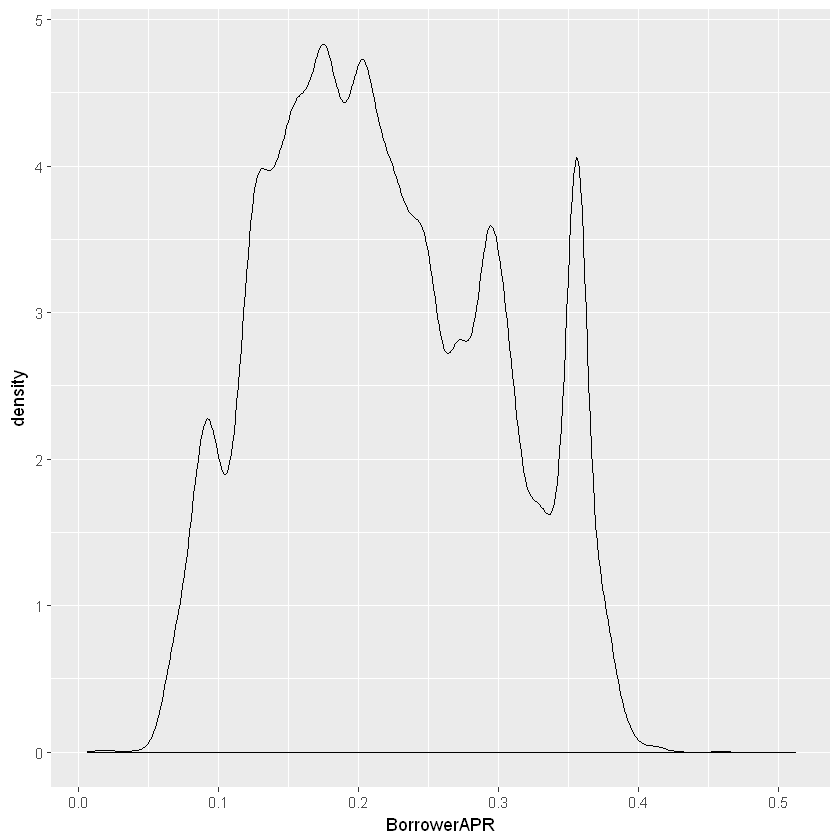

In [42]:
ggplot(datadf, aes(BorrowerAPR)) + geom_density()
+ geom_segment(x=.2)

Add lines here for popular peaks. But it is easy to see that a large amount of loans are just shy of 20% APR.

In [49]:
summary(datadf$BorrowerRate)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1340  0.1840  0.1928  0.2500  0.4975 

Here we notice that the rate is NOT the same thing as the APR. Looking at the definitions document we're simply told that the APR is the Annual Percentage Rate and that the Borrow's Rate is the borrower's interest rate for the loan. Some research tells us that these are calculated by: TODO

In [50]:
summary(datadf$EstimatedEffectiveYield)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -0.183   0.116   0.162   0.169   0.224   0.320   29084 

Warning message:
"Removed 29084 rows containing non-finite values (stat_bin)."

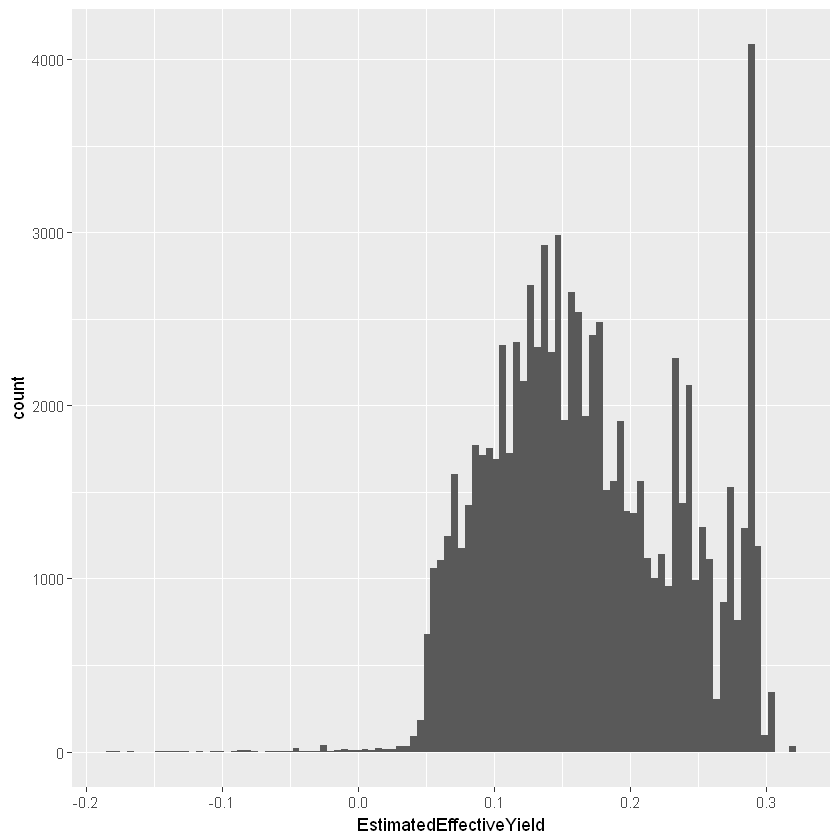

In [185]:
ggplot(datadf, aes(EstimatedEffectiveYield))+geom_histogram(bins=100)
#Why so many rows with non-finite values?

You can see that this distribution mimics the distribution of APR's but moved slightly lower, with some tail to the left as well. Might be interesting to investigate what creates the negative estimated yield loans.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    4.00    6.00    5.95    8.00   11.00   29084 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 29084 rows containing non-finite values (stat_bin)."

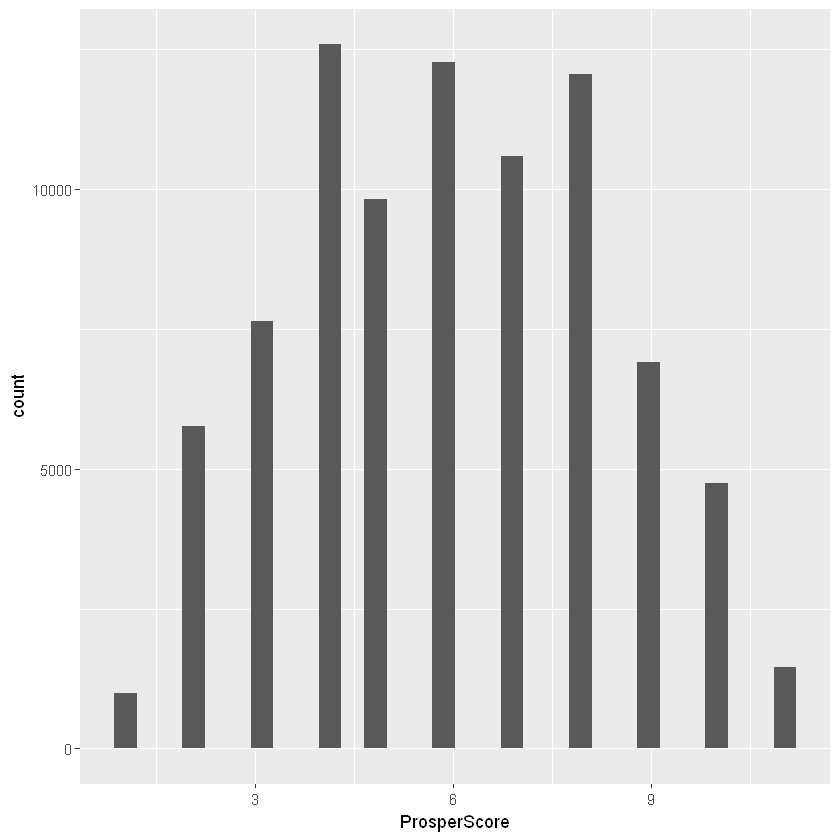

In [52]:
summary(datadf$ProsperScore)
ggplot(datadf, aes(ProsperScore)) + geom_histogram()

Here you can see that ProsperScore is discrete, and potentially bimodal? Strange clustering between 4 and 5, let's look at unique values.

In [55]:
sort(unique(datadf$ProsperScore))

[1]  1  2  3  4  5  6  7  8  9 10 11

Hmm, must be a graphing thing. 1 to 11? That's a strange scale for scoring.

In [56]:
table(datadf$ProsperScore)


    1     2     3     4     5     6     7     8     9    10    11 
  992  5766  7642 12595  9813 12278 10597 12053  6911  4750  1456 

In [19]:
unique(datadf$ListingCategory..numeric)
class(datadf$ListingCategory..numeric.)

[1]  0  2 16  1  7 13  6 15 20 19  3 18  8  4 11 14  5  9 17 10 12

[1] "integer"

The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans

It would probably be good R programming practice to put these in a dictionary and display them tabled or in a barplot. Also important to note somehow that these are a category / factor (even though it has a numeric code)
Todo: create a new, mutated column for non-numeric Listing Category. 

In [23]:
listingToCharacter <- function(numeric.category){
    listing.categories = c("Not Available", "Debt Consolidation", "Home Improvement", "Business",
                       "Personal Loan", "Student Use", "Auto", "Other", "Baby&Adoption","Boat",
                       "Cosmetic Procedure", "Engagement Ring", "Green Loans", "Household Expenses",
                       "Large Purchases", "Medical/Dental", "Motorcycle", "RV", "Taxes", "Vacation",
                       "Wedding Loans")
    return(listing.categories[numeric.category + 1]) 
}

[1]  0  2  0 16  2  1

[1] "Not Available"      "Home Improvement"   "Not Available"     
[4] "16"                 "Home Improvement"   "Debt Consolidation"

In [ ]:
#Create a non-numeric Listing category
#listing.category.df <- 
datadf %>%
mutate(ListingCategory = as.character(ListingCategory..numeric.)) %>%
case_when(ListingCategory == 0, "Not Available")


#revalue(as.character(datadf$ListingCategory), c("0" = "Not Available",
#                           "1"="Debt Consolidation",
#                           "2"="Home Improvement",
#                           "3"="Business"))
#         c(4,"Personal Loan"),
#         c(5,"Student Use"),
#         c(6,"Auto"), warn_missing=FALSE) 


In [59]:
?case_when

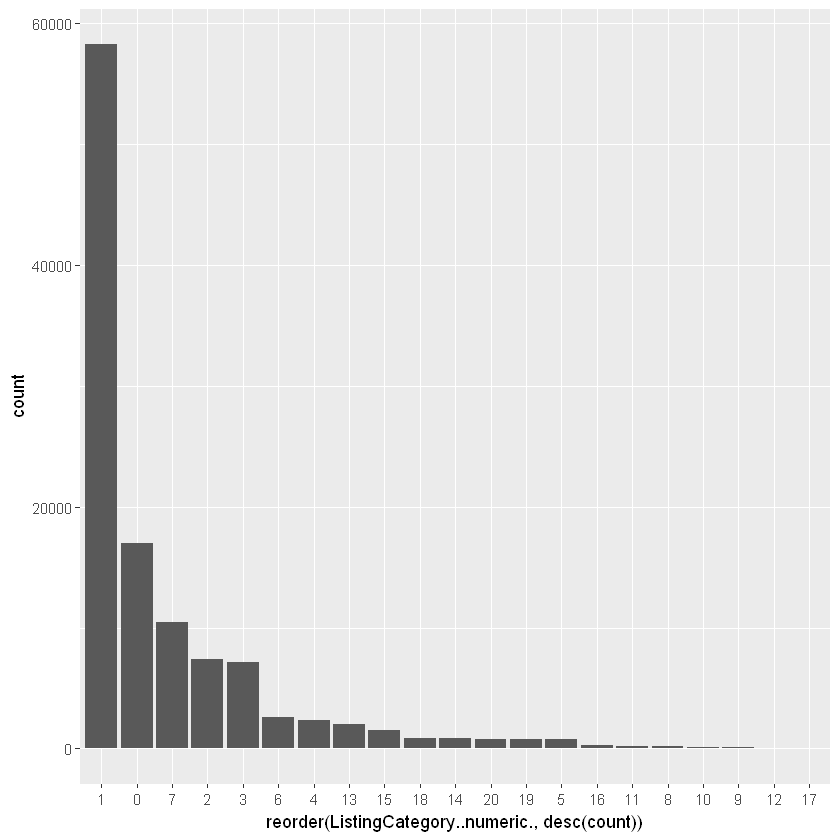

In [21]:
datadf %>%
group_by(ListingCategory..numeric.) %>%
summarise(count = n()) %>%
ggplot(aes(x=reorder(ListingCategory..numeric., desc(count)), y=count)) + geom_bar(stat="Identity")
#Wonder if I can just replace all of the numeric categories with thier string equivalents. Same for our exploration.

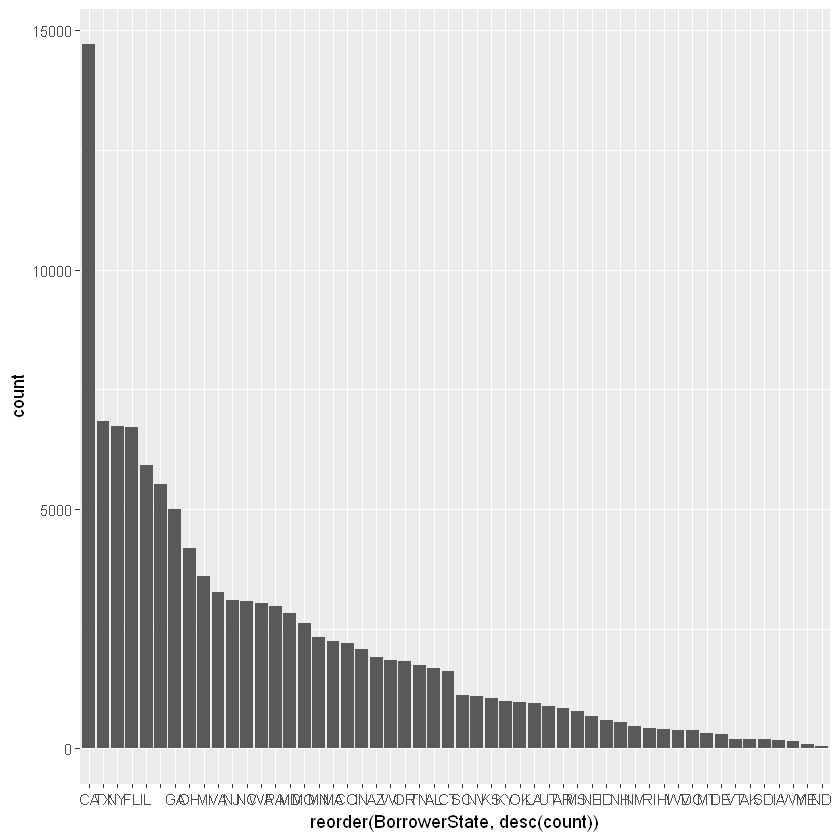

In [24]:
datadf %>%
group_by(BorrowerState) %>%
summarise(count = n()) %>%
ggplot(aes(x=reorder(BorrowerState, desc(count)), y=count)) + geom_bar(stat="Identity")
#choropleth here?
#Adjusted for population.

Would have to weight these by population of state to see if there are real differences between them.

In [29]:
datadf %>% 
group_by(Occupation) %>%
filter(Occupation != "") %>%
summarise(count = n()) %>%
arrange(desc(count))

Occupation,count
Other,28617
Professional,13628
Computer Programmer,4478
Executive,4311
Teacher,3759
Administrative Assistant,3688
Analyst,3602
Sales - Commission,3446
Accountant/CPA,3233
Clerical,3164


Again, to see if any occupation actaully had an undue number of loans we would have to compare to the population.

In [30]:
datadf %>%
group_by(EmploymentStatus) %>%
summarise(count=n()) %>%
arrange(desc(count))

EmploymentStatus,count
Employed,67322
Full-time,26355
Self-employed,6134
Not available,5347
Other,3806
,2255
Part-time,1088
Not employed,835
Retired,795


Oh, so many questions here. What does 1 represent? NA? Are some of these categories subsets of other categories? (ie Does 'Employed = Full-time+Part-Time+Self Employed"? Let's try to find out.

In [98]:
datadf$EmploymentStatus['Self Employed']

[1] <NA>
9 Levels:  Employed Full-time Not available Not employed Other ... Self-employed

In [104]:
levels(datadf$EmploymentStatus)

[1] ""              "Employed"      "Full-time"     "Not available"
[5] "Not employed"  "Other"         "Part-time"     "Retired"      
[9] "Self-employed"

In [106]:
sum(datadf$EmploymentStatus == 'Self-employed') + sum(datadf$EmploymentStatus == 'Full-time') + 
sum(datadf$EmploymentStatus == 'Part-time') 

[1] 33577

Even with the addition of 'Other' and the ill defined status '1' the categories would not approach the number of employment. Not really into this categorical variable.

In [110]:
summary(datadf$EmploymentStatusDuration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   26.00   67.00   96.07  137.00  755.00    7625 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 7625 rows containing non-finite values (stat_bin)."

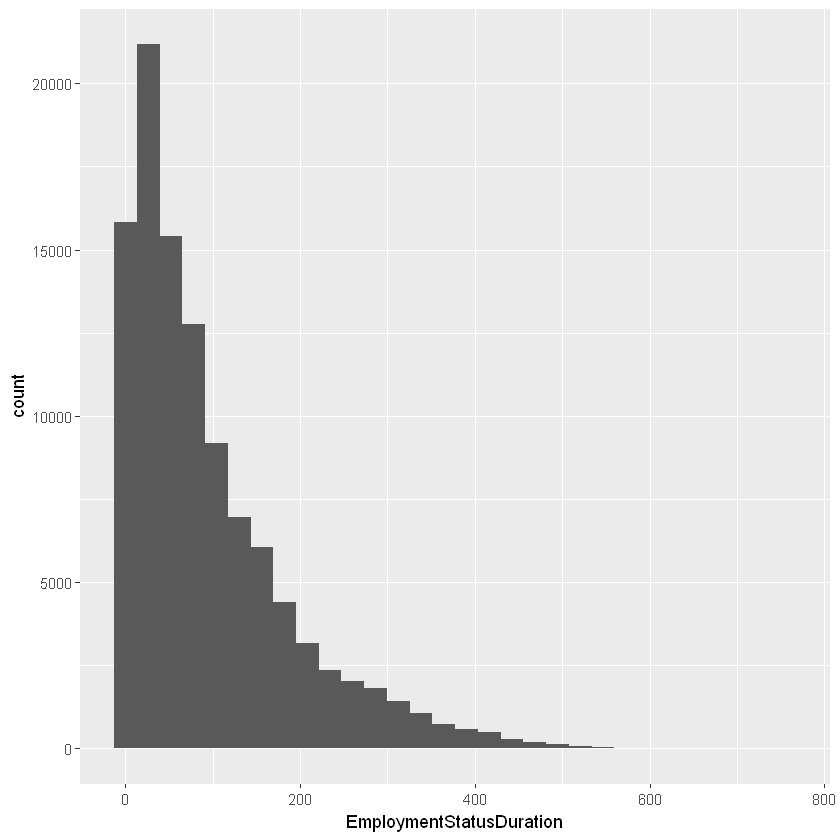

In [111]:
ggplot(datadf, aes(EmploymentStatusDuration)) + geom_histogram()

In [120]:
max(datadf$EmploymentStatusDuration, na.rm=TRUE)/12

[1] 62.91667

Looks like someone claims to have worked somewhere for almost 63 years! I guess it's possible. Maybe they're saying the've been employed for 63 years straight.

In [119]:
mean(datadf$EmploymentStatusDuration, na.rm=TRUE)/12

[1] 8.005965

In [34]:
summarise(datadf, status.mean = mean(EmploymentStatusDuration, na.rm=TRUE)/12,
         status.median = median(EmploymentStatusDuration, na.rm = TRUE)/12,
         status.min = min(EmploymentStatusDuration, na.rm = TRUE)/12,
         status.max = max(EmploymentStatusDuration, na.rm = TRUE/12))
#todo

status.mean,status.median,status.min,status.max
8.005965,5.583333,0,755


In [116]:
head(datadf$EmploymentStatusDuration)

[1]   2  44  NA 113  44  82

Nice Distribution.

Credit Range Upper and Lower. I would like to know the spread within each person, and the variance of that spread. Is this te same as Mean Upper - Mean Lower?

In [122]:
creditScoreUpper <- datadf$CreditScoreRangeUpper
creditScoreLower <- datadf$CreditScoreRangeLower

In [124]:
head(creditScoreUpper)

[1] 659 699 499 819 699 759

Warning message:
"Removed 591 rows containing non-finite values (stat_bin)."

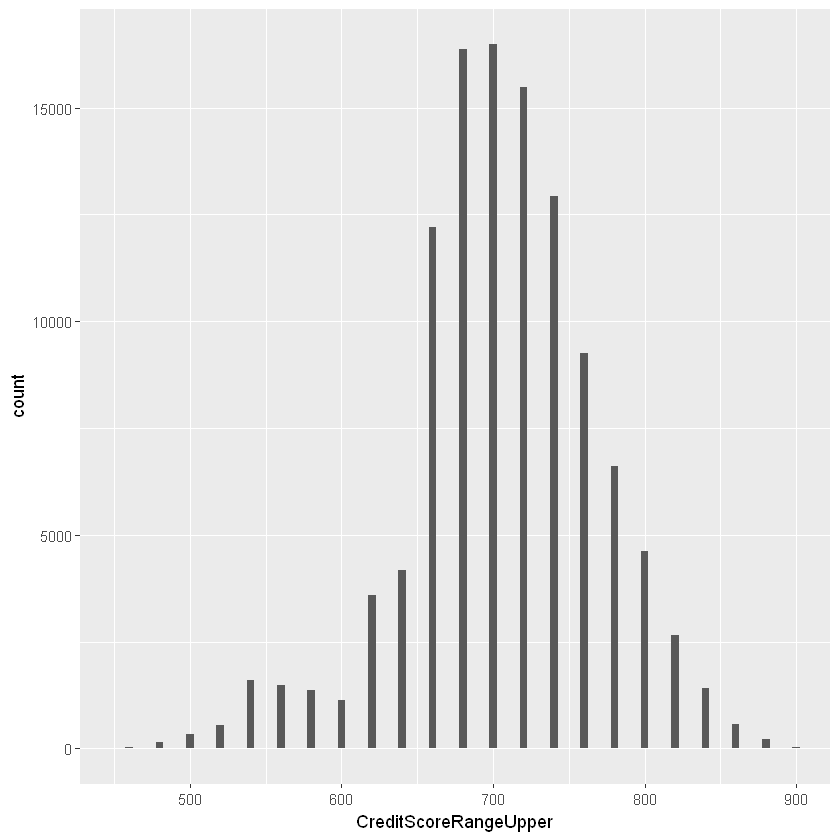

In [134]:
ggplot(datadf, aes(CreditScoreRangeUpper)) + geom_histogram(binwidth=5) + coord_cartesian(xlim=c(450,900))
#Zooming in to take because Credit Score of 0 ruins scale of histogram.

The two bumps in credit score here remind me of the bumps in APR/Rate. I'm sure there is a correlation there - more people with the same credit score more people with the same rate. I wonder how Prosper comes up with their score, is it just Fico or something more? Also it would be interesting to see what credit score distribution looks like in the general population.

Warning message:
"Removed 591 rows containing non-finite values (stat_bin)."

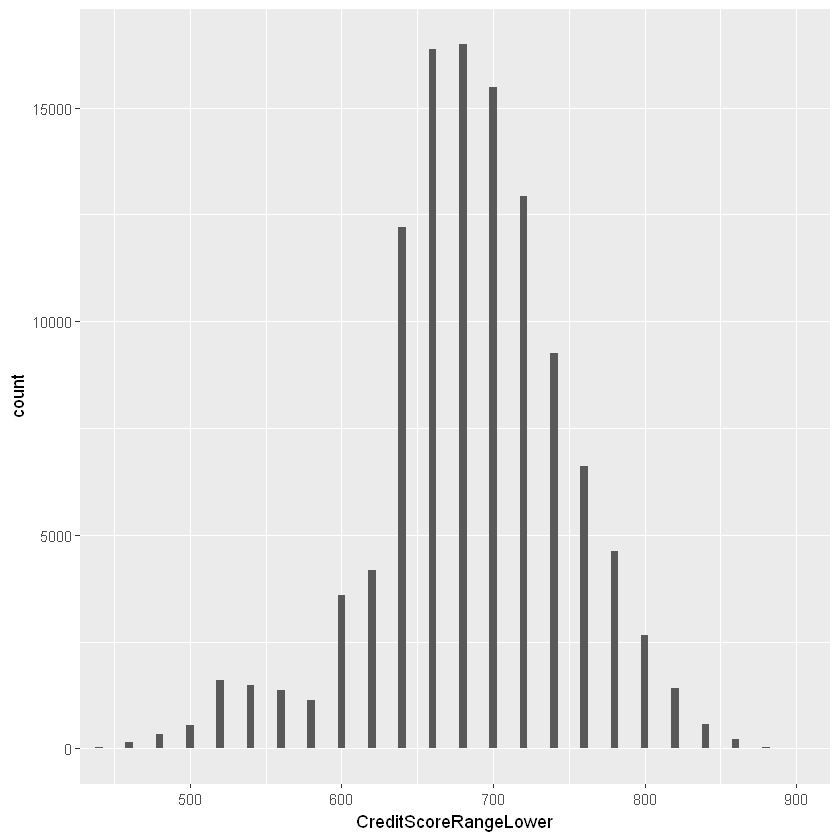

In [135]:
ggplot(datadf, aes(CreditScoreRangeLower)) + geom_histogram(binwidth=5) + coord_cartesian(xlim=c(450,900))
#Zooming in to take because Credit Score of 0 ruins scale of histogram.

Would like to plot these one over another. </br>
Are two histograms appropriate? Perhaps two density plots overlayed with low alpha
Complete: Also need to find better binwidth.

In [136]:
#Lender Yield
summary(datadf$LenderYield)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.0100  0.1242  0.1730  0.1827  0.2400  0.4925 

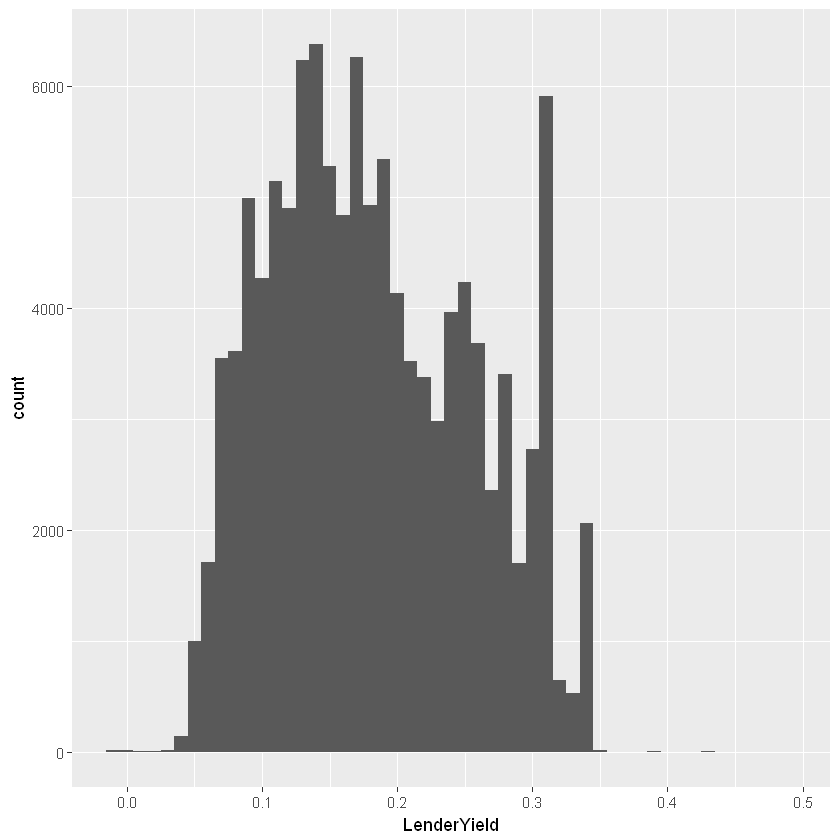

In [140]:
ggplot(datadf, aes(LenderYield)) + geom_histogram(binwidth = .01)

Density plot here? How do we best represent the spice around .3. Also, must be some pricing strategy.

In [146]:
head(datadf$EstimatedEffectiveYield)
summary(datadf$EstimatedEffectiveYield)

[1]      NA 0.07960      NA 0.08490 0.18316 0.11567

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -0.183   0.116   0.162   0.169   0.224   0.320   29084 

Warning message:
"Removed 29084 rows containing non-finite values (stat_bin)."

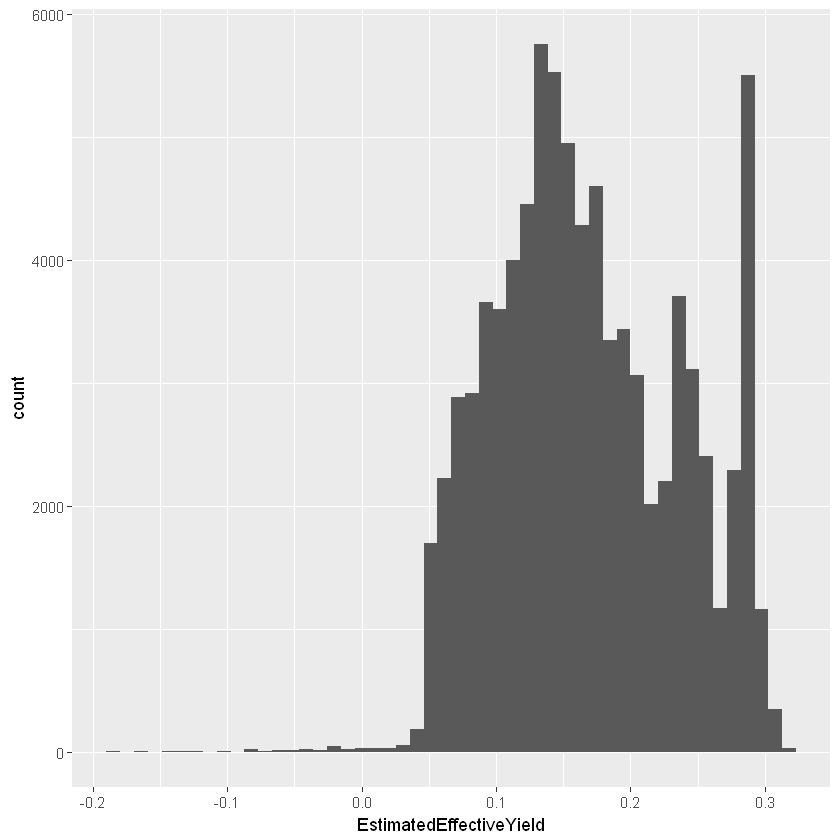

In [148]:
ggplot(datadf, aes(EstimatedEffectiveYield)) + geom_histogram(bins=50)

Related to Lender Yield - perhaps I could find hte adjustment between the two?

In [150]:
head(datadf$ProsperScore)
summary(datadf$ProsperScore)

[1] NA  7 NA  9  4 10

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    4.00    6.00    5.95    8.00   11.00   29084 

Scale is a little strange to me, why is max 11?

Warning message:
"Removed 29084 rows containing non-finite values (stat_count)."

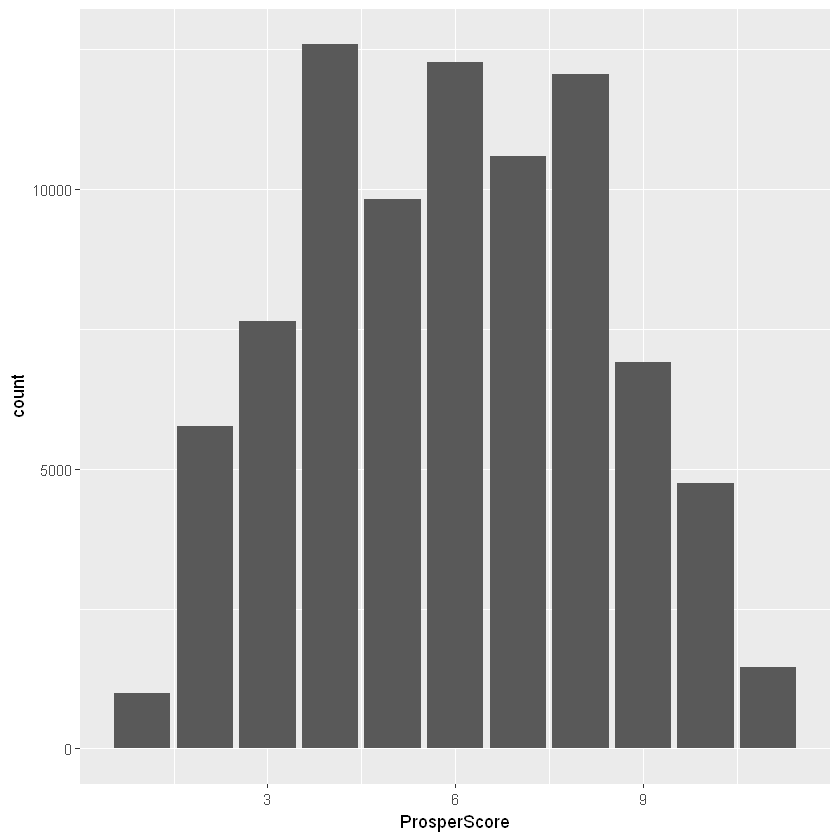

In [151]:
ggplot(datadf, aes(ProsperScore)) + geom_bar()

Ah, it's really a 0-10 scale transposed one to the right. Nice distribution. Accidentally went through this one twice.

In [155]:
head(datadf$IncomeRange)
#Ordered Data
#Is there a way to see how many potential values contained in this column? Perhaps unique()
sort(unique(datadf$IncomeRange))
#Close enough for me to read.

[1] $25,000-49,999 $50,000-74,999 Not displayed  $25,000-49,999 $100,000+     
[6] $100,000+     
8 Levels: $0 $1-24,999 $100,000+ $25,000-49,999 ... Not employed

[1] $0             $1-24,999      $100,000+      $25,000-49,999 $50,000-74,999
[6] $75,000-99,999 Not displayed  Not employed  
8 Levels: $0 $1-24,999 $100,000+ $25,000-49,999 ... Not employed

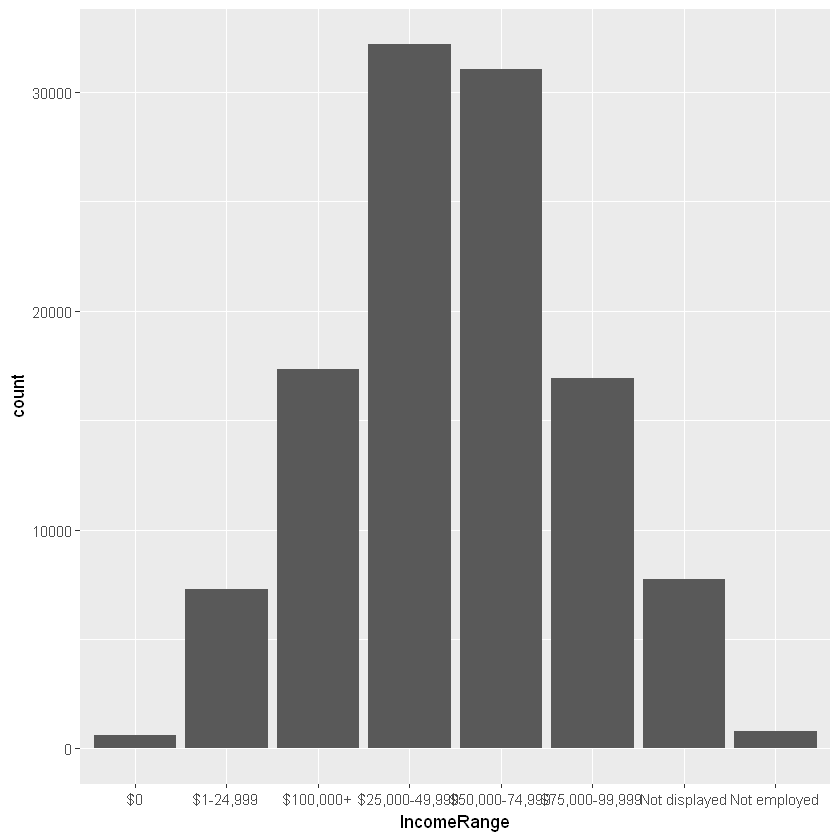

In [156]:
ggplot(datadf, aes(IncomeRange)) + geom_bar()

Looks like a distribution, but actually the factors? on the right are separate. Also, cutting off after 100k+ is interesting, but gives us less to work with. Also, $0 == Not Employed.

In [157]:
head(datadf$IncomeVerifiable)

[1] True True True True True True
Levels: False True

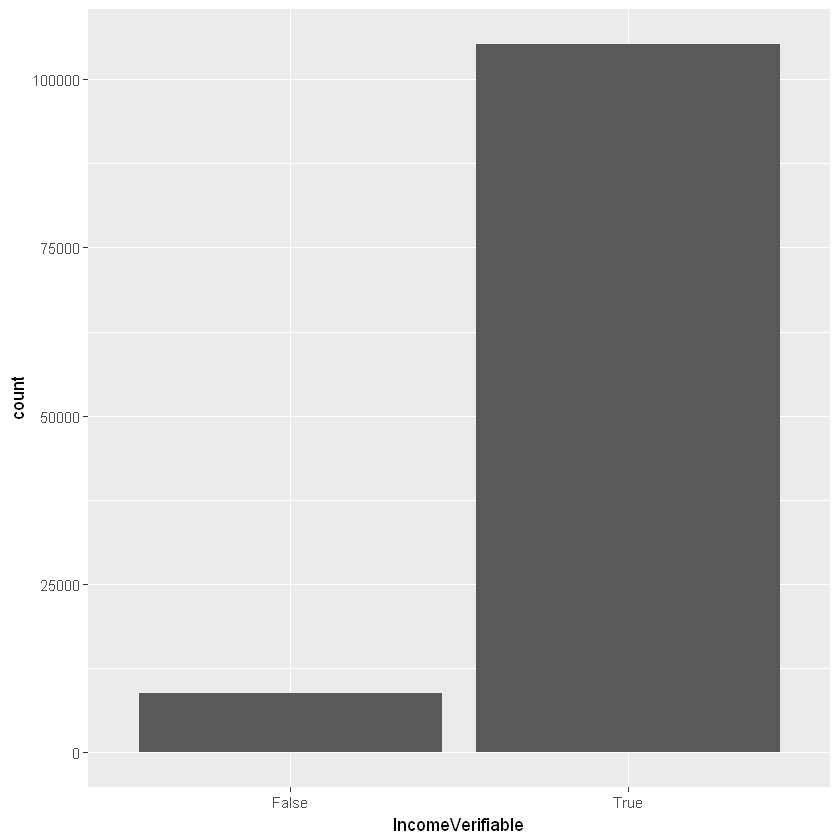

In [158]:
ggplot(datadf, aes(IncomeVerifiable)) + geom_bar()

I wonder what the aspects of a loan where the income isn't verified are. Will investigate.

In [160]:
head(datadf$MonthlyLoanPayment)
summary(datadf$MonthlyLoanPayment)

[1] 330.43 318.93 123.32 321.45 563.97 342.37

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   131.6   217.7   272.5   371.6  2252.0 

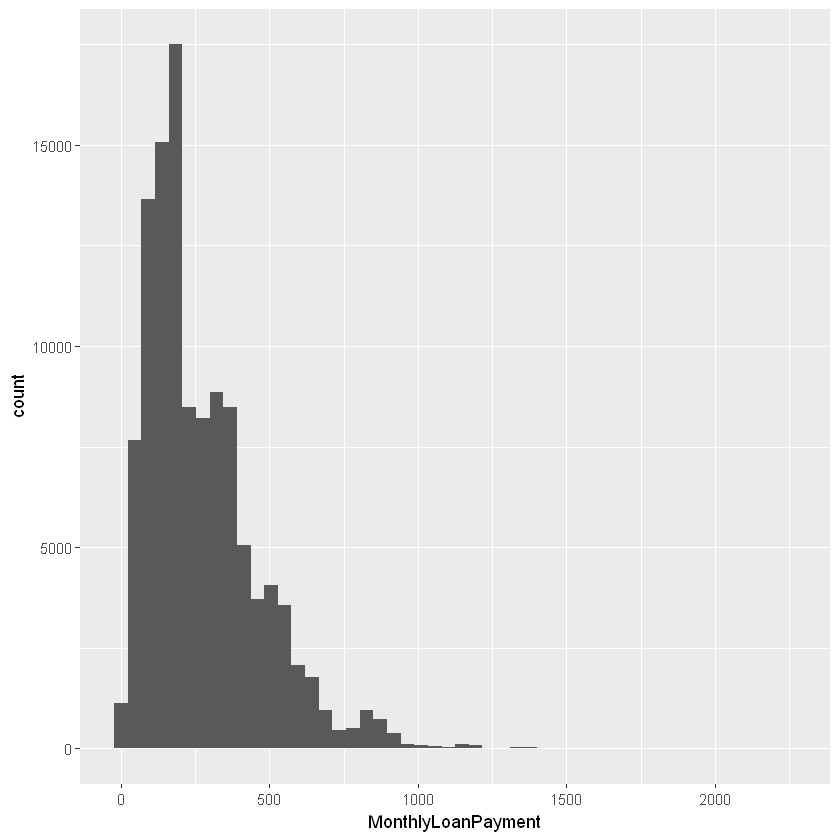

In [163]:
monthlyPayment <- ggplot(datadf, aes(MonthlyLoanPayment)) + geom_histogram(bins=50)
monthlyPayment

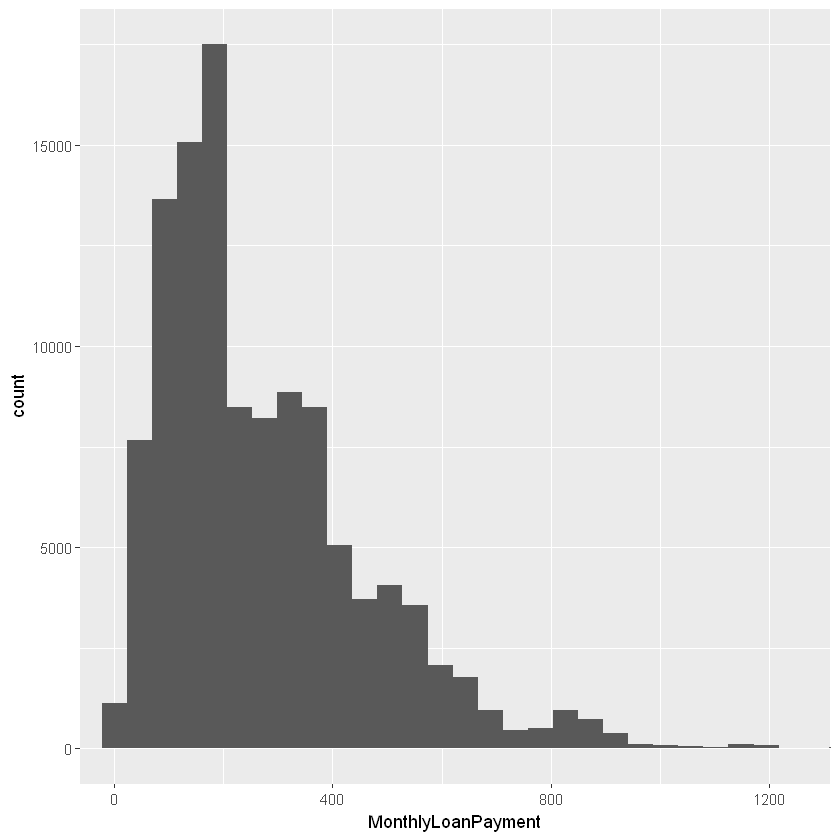

In [166]:
#Looks like there's a big outlier there with our max  22252. But our histogram makes it hard to see this. Let's zoom in.
monthlyPayment + coord_cartesian(c(0,1250))

After 200 there is a sharp drop off in monthly payments. There must be something here. I wonder if it's related to income or debt to income, or perhaps the amount of money people usually need. How big are these loans?

[1]  9425 10000  3001 10000 15000 15000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    4000    6500    8337   12000   35000 

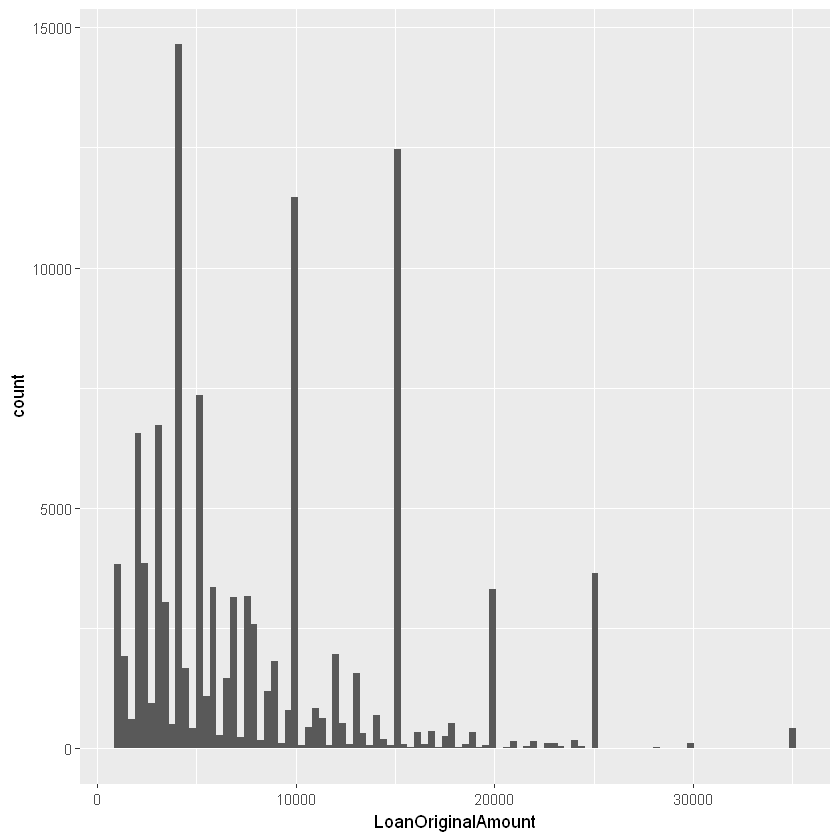

In [171]:
head(datadf$LoanOriginalAmount)
summary(datadf$LoanOriginalAmount)
ggplot(datadf, aes(LoanOriginalAmount)) + geom_histogram(bins=100)
#how could I mike the bins seperate by 500's or 100's?

[1] 1 1 1 1 1 1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7000  1.0000  1.0000  0.9986  1.0000  1.0120 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


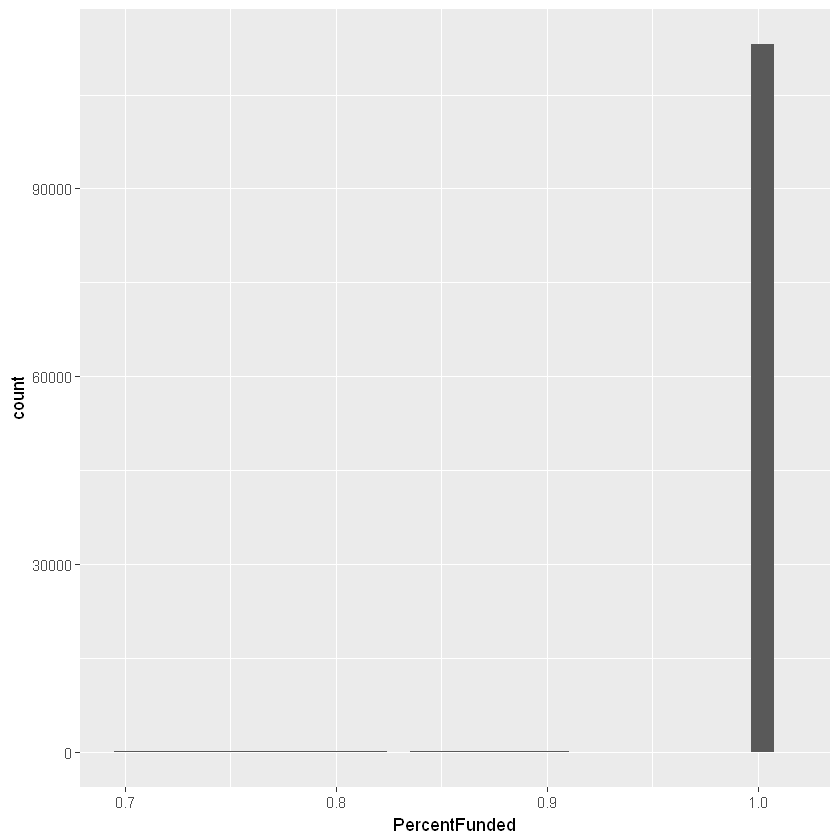

In [173]:
head(datadf$PercentFunded)
summary(datadf$PercentFunded)
ggplot(datadf, aes(PercentFunded)) + geom_histogram()

OK, so it looks like the vast percentage were 100% funded. Let's take a closer look at those that weren't.
todo: get number of total that were funded entirely

In [174]:
ggplot(datadf, aes(PercentFunded)) + geom_histogram() + coord_cartesian(
#I think filter works here

In [211]:
summary(datadf$Investors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00   44.00   80.48  115.00 1189.00 

Should be related to the size of the loan.

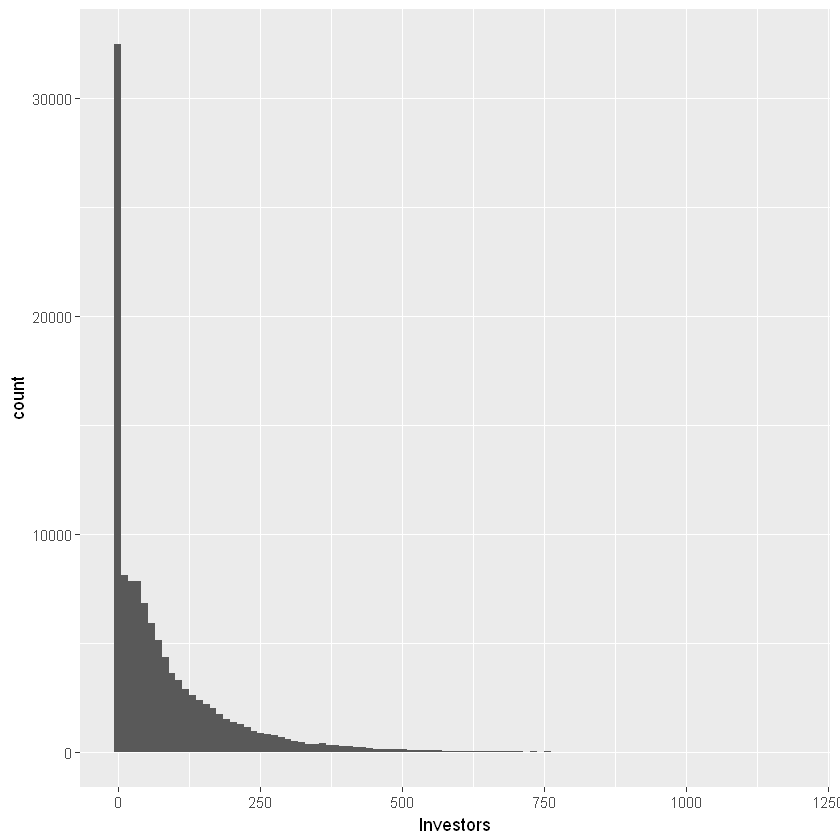

In [214]:
ggplot(datadf, aes(Investors)) + geom_histogram(bins=100)

Wow, in a a platform that lets you pool your risk, a lot of loansstill only have 1... Or is that 0?

In [218]:
table(datadf$Investors)[1:10]


    1     2     3     4     5     6     7     8     9    10 
27814  1386   991   827   753   721   701   753   721   728 

Deffinitely 1! Yikes. Can't wait to see what causes that.

1 - Term 
#####LoanStatus = Need tto group loans efffectively first
BorrowerAPR
Estimated Effective Yield / Yield would have had
#####Income Range
#####Loan Amount

Warning message:
"Removed 25 rows containing non-finite values (stat_boxplot)."

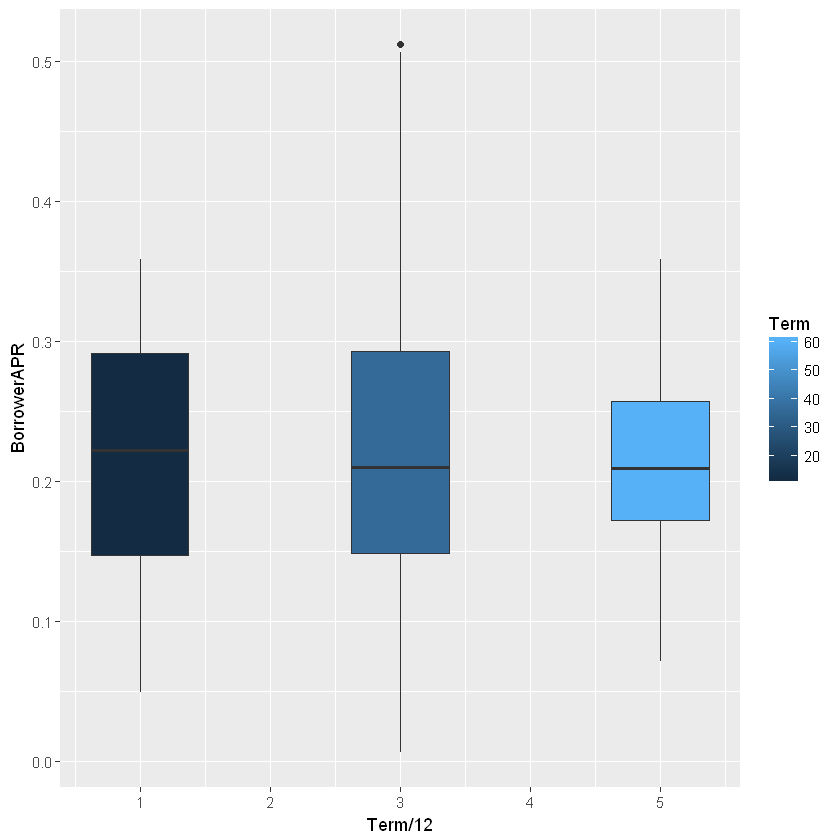

In [12]:
ggplot(datadf, aes(group=Term, x=Term/12, y=BorrowerAPR)) + geom_boxplot()

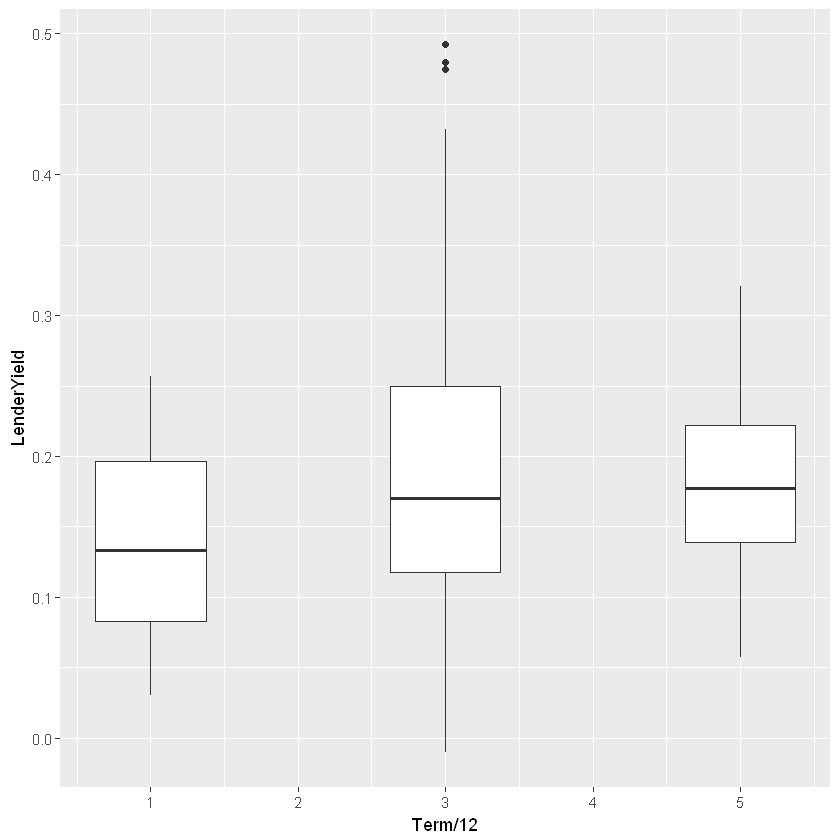

In [16]:
ggplot(datadf, aes(group=Term, x=Term/12, y=LenderYield)) + geom_boxplot()

Well that's interesting, but in hindsight pretty obvious. Though the median(?) Borrower APR stays flat over the three terms, the expect yield increases. That makes sense though, seeing that given 2 loans of the same amount with the same APR the one with the longer term will have a higgher yield. (More payments, more time to collect interest, etc.

Warning message:
"Removed 29084 rows containing non-finite values (stat_boxplot)."

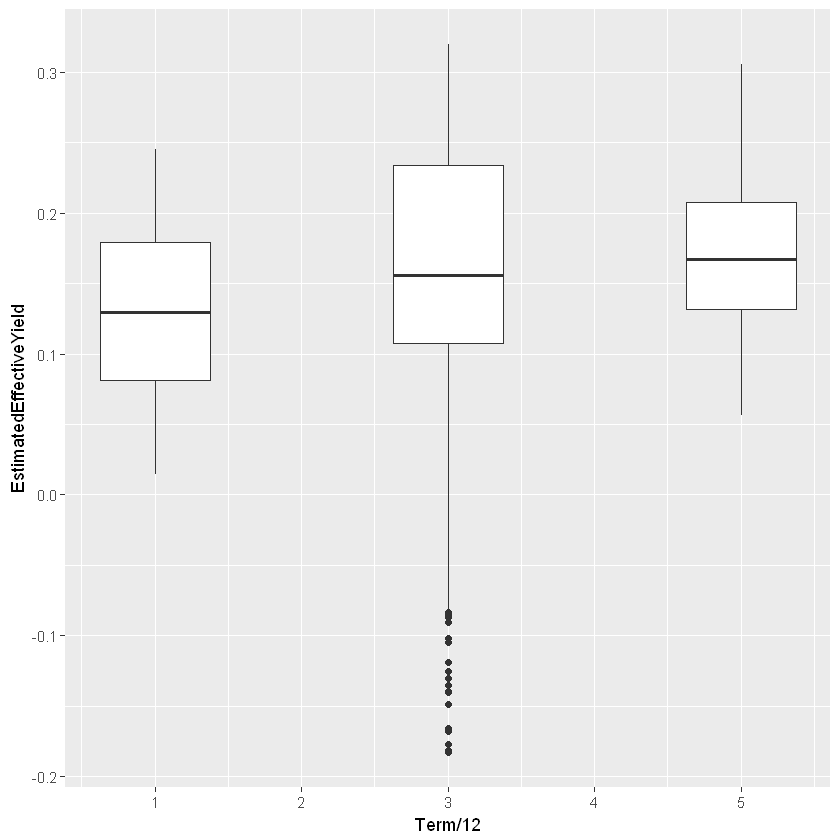

In [18]:
#Let's look at the same thing for Estimated Effective Yield
ggplot(datadf, aes(group=Term, x=Term/12, y=EstimatedEffectiveYield)) + geom_boxplot()

The term's relationship to one another stay static, but there are a bunch of outliers with negative Estimated Effective Yield, and only in the 3 year term. Let's take a look atht those loans.

In [19]:
negativeExpectedYield <- datadf %>%
filter(EstimatedEffectiveYield <= 0)

In [20]:
negativeExpectedYield

ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
089C348555489823736377D,460749,2010-05-30 18:37:24.953000000,,36,Chargedoff,2013-01-11 00:00:00,0.24807,0.2100,0.2000,...,-15.46,0.00,383.08,383.08,0,1,0,0,0.00,31
32543499181220496DBB555,483095,2010-11-05 14:46:00.163000000,,36,Completed,2011-04-21 00:00:00,0.36783,0.3269,0.3169,...,-5.91,0.00,0.00,0.00,0,1,0,1,1058.77,27
4685347195009875809A70E,440607,2010-01-01 14:46:53.843000000,,36,Completed,2011-02-28 00:00:00,0.22491,0.2000,0.1900,...,-14.35,0.00,0.00,0.00,0,1,0,0,0.00,75
6DD034810270651087DFB9F,452658,2010-04-05 09:10:40.280000000,,36,Completed,2011-04-29 00:00:00,0.36336,0.3390,0.3290,...,-13.30,0.00,0.00,0.00,0,1,0,1,100.00,60
0B5C34738042854656430E6,441714,2010-01-08 13:39:38.123000000,,36,Chargedoff,2012-01-22 00:00:00,0.37453,0.3500,0.3400,...,-24.48,-5.95,1170.57,1170.57,0,1,0,0,0.00,24
421F3494976253733186DF9,477067,2010-09-25 12:10:55.217000000,,36,Chargedoff,2011-05-10 00:00:00,0.38620,0.3490,0.3390,...,-12.44,0.00,7256.40,7256.40,0,1,0,0,0.00,61
9E5E3498204991686FFFDC9,481925,2010-10-28 10:18:14.733000000,,36,Completed,2011-05-13 00:00:00,0.34631,0.3100,0.3000,...,-31.49,0.00,0.00,0.00,0,1,0,0,0.00,75
06C634936764915582779CD,474698,2010-09-07 07:57:07.080000000,,36,Chargedoff,2013-05-18 00:00:00,0.37699,0.3400,0.3300,...,-123.99,0.00,2684.45,2684.45,0,1,0,0,0.00,37
0F393487035940130A9724B,463090,2010-06-18 09:24:37.347000000,,36,Completed,2011-02-18 00:00:00,0.33281,0.3089,0.2989,...,-35.39,0.00,0.00,0.00,0,1,1,1,25.00,169
3AA83459022108282F14863,416980,2009-07-17 13:57:20.620000000,,36,Completed,2012-05-23 00:00:00,0.37453,0.3500,0.3400,...,-24.61,0.00,0.00,0.00,0,1,0,0,0.00,1


The first thing that jumps out is that they are all either completed or Charged off. Perhaps the completed ones were paid early, and with fees their yield bacome negative? Chargedoff Loans the lender is losting out on , period - by why do they seem so prevalent in the middle term?

In [23]:
summary(negativeExpectedYield)

                   ListingKey  ListingNumber   
 009B3495741061236C0C927:  1   Min.   :416595  
 02283482060850607BC27FE:  1   1st Qu.:433135  
 02933496318097934A683F4:  1   Median :456357  
 029A3499706893097DB1393:  1   Mean   :455962  
 038535015703591930CD2E0:  1   3rd Qu.:477670  
 03AA34675425410661C8213:  1   Max.   :487169  
 (Other)                :185                   
                    ListingCreationDate  CreditGrade       Term   
 2009-07-14 21:09:50.017000000:  1             :191   Min.   :36  
 2009-07-17 13:57:20.620000000:  1      A      :  0   1st Qu.:36  
 2009-07-23 16:16:18.167000000:  1      AA     :  0   Median :36  
 2009-07-31 15:25:54.323000000:  1      B      :  0   Mean   :36  
 2009-07-31 15:41:11.917000000:  1      C      :  0   3rd Qu.:36  
 2009-08-04 12:24:33.823000000:  1      D      :  0   Max.   :36  
 (Other)                      :185      (Other):  0               
                  LoanStatus                ClosedDate   BorrowerAPR     
 Compl

147 Completed, 42 Charged off in this subset. Definitely want to take a closer look at the completed.
Median borrower APR: .28902
Todo: Difference between Rate and APR
EstimatedLoss : would also be good to look at. Median .345
Can look at their prosperScores. 
Occpation: 'Other' is way out in front. Is this due to a high portion of the pop nbnot having one of the listed jobs?
Credit is confusing here because this group also contains complete, likely paid off early loans.
WOnder if I could find 'the most ridiculous loan issued?
Income Range of Charged off Loans. 
Income Verified?
Propser Principal Borrowed - didnt even know about this variable.
ProsperPrincipal Outstanding
LoanFirstDefaultedCycleNumber
LoanMonthsSinceOrigination
Loan Original Amount - how is this different from ProsperPrincipalBorrowed?
LPCustomerPrincipalPayments

In [32]:
#The question is: does a person's income affect the term of the loan they take out.
#put all the names of the income groups in a vector
summary(datadf$IncomeRange) #to check names

$0      $1-24,999      $100,000+ $25,000-49,999 $50,000-74,999 
           621           7274          17337          32192          31050 
$75,000-99,999  Not displayed   Not employed 
         16916           7741            806

In [66]:
levels(datadf$IncomeRange)

[1] "$0"             "$1-24,999"      "$25,000-49,999" "$50,000-74,999"
[5] "$100,000+"      "Not displayed"  "Not employed"

In [65]:
datadf$IncomeRange <- factor(datadf$IncomeRange, levels = c("$0", "$1-24,999", "$25,000-49,999", "$50,000-74,999", 
                                                            "$100,000+", "Not displayed", "Not employed"))

In [67]:
dim(datadf)
with_income_info <- datadf %>%
filter(!IncomeRange %in% c('Not displayed','Not employed'))
dim(with_income_info)

[1] 113937     81

[1] 105390     81

In [ ]:
#makes sense to use percentage here, or comparing apples to oranges.
#So that is Count of Income Using that Term / Count of People with that Income
income_facet <- ggplot(with_income_info, aes(Income Range)) + geom_bar()

Warning message:
"position_dodge requires non-overlapping x intervals"

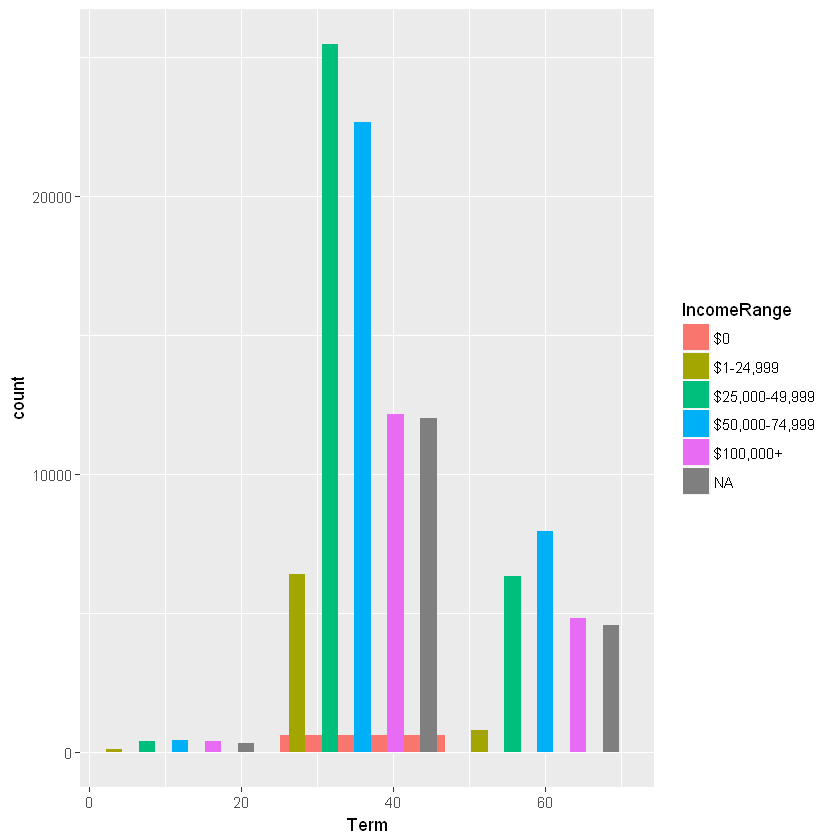

In [74]:
ggplot(with_income_info, aes(Term, fill=IncomeRange)) + geom_bar(position="dodge") 

Don't know how to automatically pick scale for object of type grouped_df/tbl_df/tbl/data.frame. Defaulting to continuous.


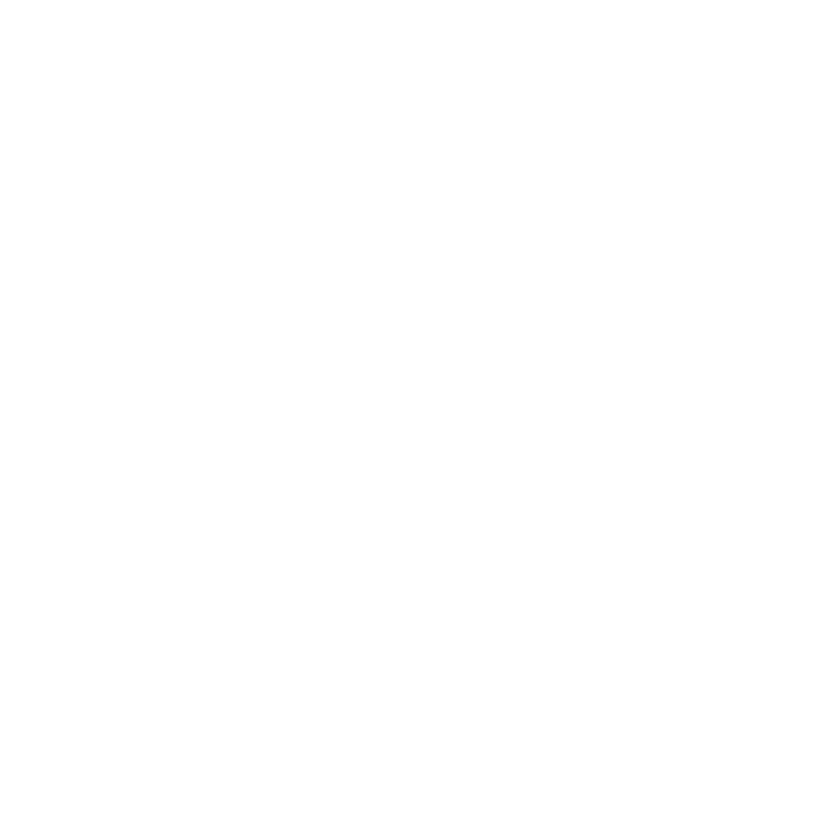

In [53]:
#plotting term count grouped by incomerange, income range with term 
p <- with_income_info %>% group_by(IncomeRange) %>% count(Term) %>% arrange(IncomeRange, Term)
ggplot(p, aes(Term))+geom_bar()
#this deffinitely creates the right table - need to figure out how to plot it
#might have to add 12 mo term to 0
#OK - so doesn't like trying to plot 'objects of type grouped'. can i ungroup them or r
#coerce them into being something else/

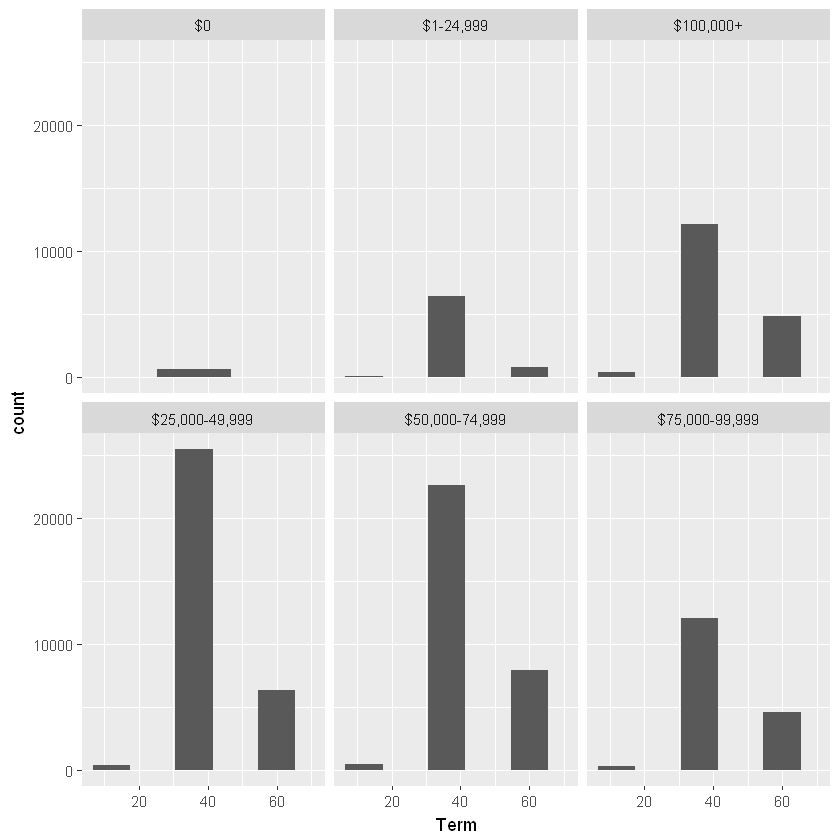

In [63]:
ggplot(with_income_info, aes(Term)) + geom_bar() + facet_wrap(~IncomeRange)

#these graphs are still deficient because they're absolute, not perncentage /density

In [21]:
#for each income bucket, what percentage of loans are whic term
datadf %>%
filter(IncomeRange )
group_by(IncomeRange, Term) %>%
summarise(number_of_loans = n()) %>%
mutate(freq = number_of_loans / sum(number_of_loans)) 


ERROR: Error in filter_impl(.data, dots): filter condition does not evaluate to a logical vector. 


In [12]:
#for each income bucket, what percentage of loans are whic term
datadf %>%
select(ListingKey, Term, IncomeRange) %>%
group_by(IncomeRange) %>%
mutate(number_of_loans = n()) %>%
group_by(Term) %>%
summarize(percentage_term = n())

Term,percentage_term
12,1614
36,87778
60,24545
